In [38]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display

# 데이터 불러오기

In [39]:
from data_preprocess import preprocessing

In [40]:
base_path = '2022-03-07/'
file_paths = [
    base_path + 'bestshots.json', 
    base_path + 'items.json', 
    base_path +'categories.json', 
    base_path +'products.json'
]

In [41]:
products_df_4, products_df_b = preprocessing(file_paths)
products_df_4.shape, products_df_b.shape

/Users/ruo/Desktop/codestates/CP2/data_preprocess.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


((4211, 10), (46576, 10))

### 유저별 아이템셋

In [42]:
itemsets_4 = products_df_4.groupby('projectId')[['product_id', 'name']].agg(list).reset_index()
itemsets_b = products_df_b.groupby('projectId')[['product_id', 'name']].agg(list).reset_index()
itemsets_4.shape, itemsets_b.shape

((250, 3), (3160, 3))

# item2vec model

In [43]:
from gensim.models import Word2Vec

In [44]:
def build_model(df):
    sentence = df['name'].values.tolist()
    embedding_model = Word2Vec(sentence, vector_size=20, window = 5, 
                               min_count=1, workers=4, epochs=200, sg=1)
    return embedding_model

In [49]:
def get_rec_result(df, products_df, model, search_word_list, topn=10):
    # 유사도를 통해 추천
    result = model.wv.most_similar(positive=search_word_list, topn=topn)
    
    # 선택한 이미지들 보여주기
    for search_word in search_word_list:
        print(f'사용자가 선택한 아이템 : {search_word}')
        search_images = products_df[products_df['name'] == search_word]['images'].values.tolist()[0]
        try:
            res = requests.get(search_images[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
    
    print("="*80)
    print(f"추천 아이템 Top{topn}")
    print("="*80)
    
    # 추천된 이미지들 보여주기
    for i, (name, _) in enumerate(result):
        images = products_df[products_df['name'] == name]['images'].values.tolist()[0]
        try:
            res = requests.get(images[0])
            img = Image.open(BytesIO(res.content))
            display(img)
        except:
            print('이미지 없음\n')
        print(f'{i+1}순위 추천 아이템 : {name}')
        print("-"*60)
    
    return result

In [46]:
itemsets_b

,projectId,product_id,name
0,X03kkmq3F0385EA5C764AE6,"[D6117F42A4954E3E, XjDwfV4680E5354793B4C19, 6F...","[화이트 정사각 LED 방등 화이트, 코코 패브릭 3인 소파 (베이지), 알로카시아..."
1,X0DG-R365501D4F10C44991,"[1F48BD9B4D74402D, F30E29AC6AAF4EBF, B837811DC...","[Archisketch TV Media, 고양이 캣휠, 고양이 원목 캣타워 DIY ..."
2,X0F4LrPB3C3113053B540A7,"[XZghYJf82678C8EFD1A44F4, XPZLv0Q47395C4AAE6A4...","[내츄럴 원목 후크선반 (레드우드), BC5719 테미스 3단 틸팅전면책장 DVX,..."
3,X0I2BuKAEB365CDB09F4B96,"[A7AE5ED7BC3B4ABD, CE906CAE0B5149C9, 8079E4F6F...","[몬스테라_우드 스탠드화분(중), Archisketch Etc Poster 9111..."
4,X0Ntnsv80F53E9104804254,"[1F631AD4C32C4109, 1F631AD4C32C4109, 1F631AD4C...","[Archisketch Standard Curtain, Archisketch Sta..."
...,...,...,...
3155,XzoeG9K4E19B2A3C44342AF,"[8E8E934BA51C4D77, XYW24m11D816D20931F487F, DE...","[데코용 도자기 (검정 01), 멜랑 충전식 LED 무드등 SL-A01, Archi..."
3156,XzqGokw4C96DFD0E9634FE9,"[291AC17286114A1A, XOZZzMJ5B28A7993B144D22, Xi...","[무풍에어컨 AR07R5173HC, 뽀송 10L 제습기 DXAH100-IWK, 미지..."
3157,Xzrao7B8FC2F792A389477B,"[9685F6318BD040E1, Xkcu5jx972E120FC2544CDB, Xc...","[호텔식 화이트 시폰 커튼, 스튜디오촬영소품 breeze (50x70), BULUH..."
3158,XzrdVqA3C7467C7138A401E,"[783FCAAD71F44652, CD19994DA328473C, XezUkFZ4E...","[32인치 게이밍모니터 QX3268 REAL165, 디지털피아노 MU-8H NEW웨..."


### 모델 훈련

In [47]:
emb_model_b = build_model(itemsets_b)

사용자가 선택한 아이템 : 화이트 정사각 LED 방등 화이트


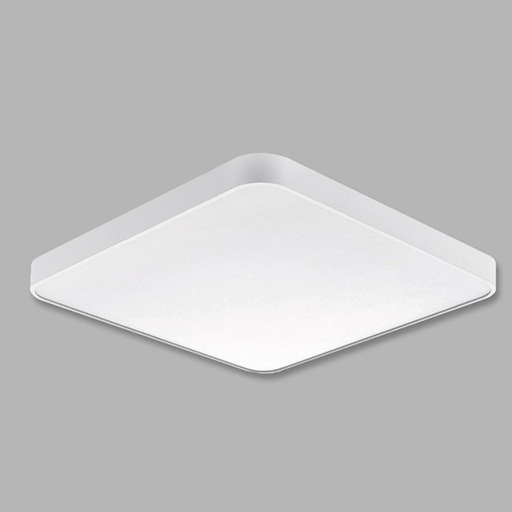

추천 아이템 Top10


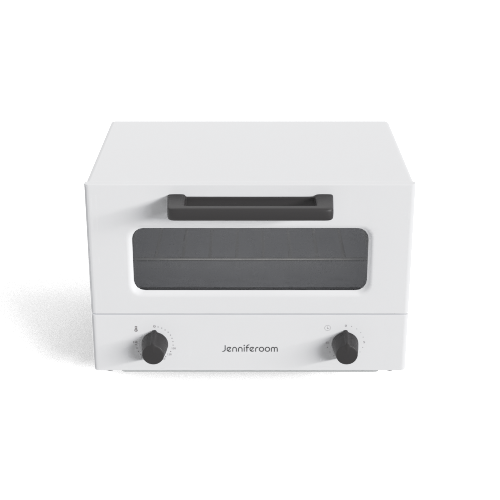

1순위 추천 아이템 : 미니 오븐토스터 화이트 (화이트)
------------------------------------------------------------


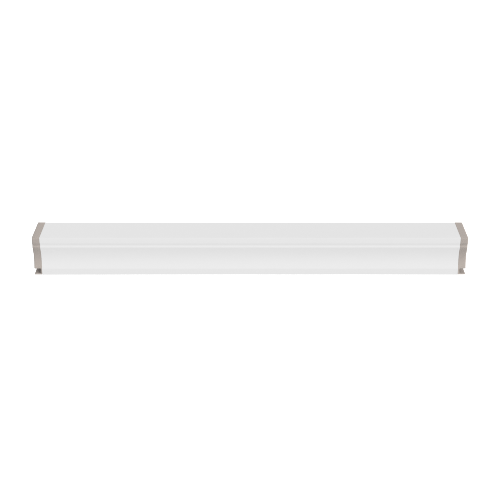

2순위 추천 아이템 : 무선LED 센서등 멀티탁 (옐로우) (20.5)
------------------------------------------------------------


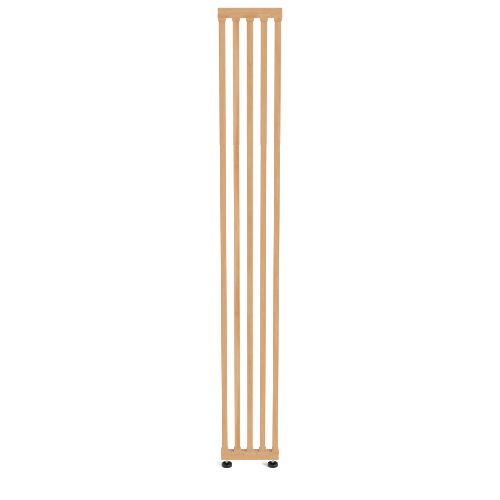

3순위 추천 아이템 : 파티션 (메이플)
------------------------------------------------------------
이미지 없음

4순위 추천 아이템 : Archisketch Latte Cup
------------------------------------------------------------
이미지 없음

5순위 추천 아이템 : Archisketch Standard Curtain
------------------------------------------------------------


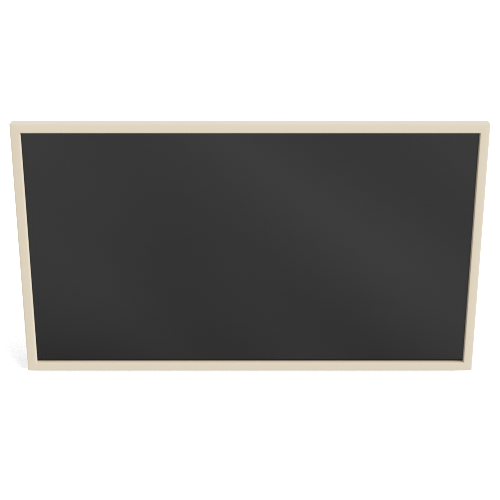

6순위 추천 아이템 : QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(벽걸이)(베이지)
------------------------------------------------------------


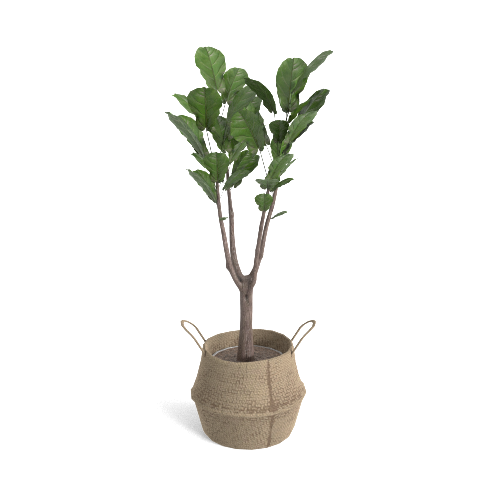

7순위 추천 아이템 : 대형 떡갈고무나무 인테리어 식물 (해초바구니set) (화이트)
------------------------------------------------------------


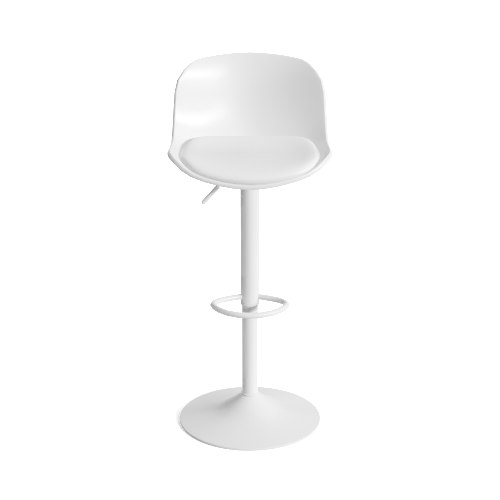

8순위 추천 아이템 : 루시 아일랜드식탁의자 회전 높이조절 (화이트)
------------------------------------------------------------


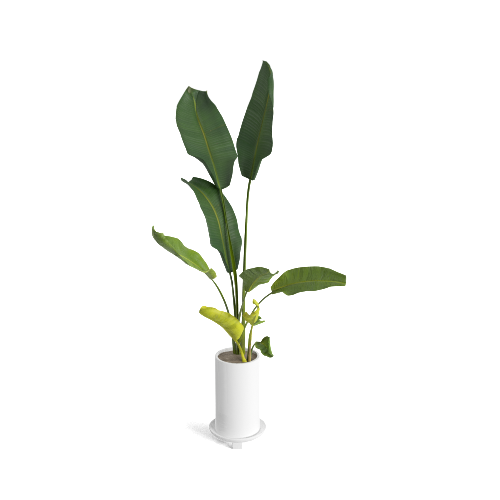

9순위 추천 아이템 : 여인초 대형 테라조 화분세트 (2촉)
------------------------------------------------------------


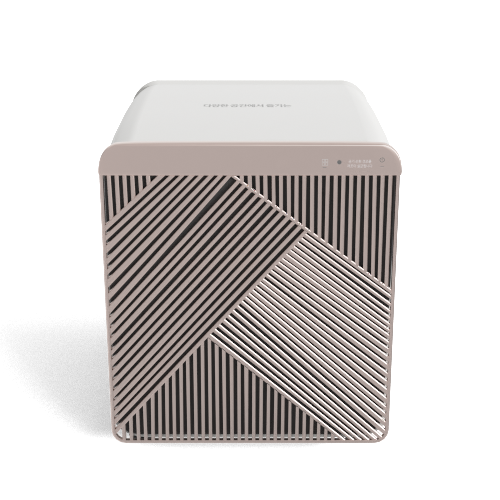

10순위 추천 아이템 : 비스포크 무풍 큐브 공기청정기 AX53A9310GED 53㎡ (브라운)
------------------------------------------------------------


[('미니 오븐토스터 화이트 (화이트)', 0.8857385516166687),
 ('무선LED 센서등 멀티탁 (옐로우) (20.5)', 0.8842796087265015),
 ('파티션 (메이플)', 0.8571265339851379),
 ('Archisketch Latte Cup', 0.8546925783157349),
 ('Archisketch Standard Curtain', 0.8527796268463135),
 ('QLED TV 더프레임 189cm(75) KQ75LST03AFXKR(벽걸이)(베이지)', 0.8487270474433899),
 ('대형 떡갈고무나무 인테리어 식물 (해초바구니set) (화이트)', 0.8477030396461487),
 ('루시 아일랜드식탁의자 회전 높이조절 (화이트)', 0.8418693542480469),
 ('여인초 대형 테라조 화분세트 (2촉)', 0.8377426862716675),
 ('비스포크 무풍 큐브 공기청정기 AX53A9310GED 53㎡ (브라운)', 0.8292813301086426)]

In [50]:
search_word_list = ['화이트 정사각 LED 방등 화이트']

get_rec_result(itemsets_b, products_df_b, emb_model_b, search_word_list, topn=10)